In [66]:
% matplotlib notebook
import json
from utils import *

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from scipy.signal import wiener

import math
import scipy

from kalman_filtering import oneIterPowerKalmanFilter

from indicator_simulation import *

<IPython.core.display.Javascript object>


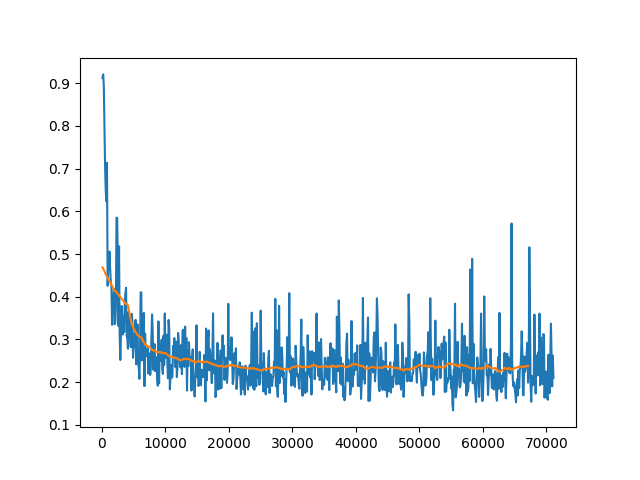

62600 0.22472715929702478 671
49700 0.23997036983937392


In [67]:
# data_file = 'jsons/val_err_wo_lr_decay.json'
# data_file = 'jsons/val_err.json'
# data_file = 'jsons/bs_32_val_err.json'
# data_file = 'jsons/imagenet_dataset0.json'
# data_file = 'jsons/cifar_all_lr_5e_2.json'
data_file = 'jsons/cifar_all_lr_1e_1.json'
# data_file = 'jsons/cifar_all_lr_8e_2.json'

with open(data_file) as f:
    val_acc = json.load(f)

val_err = 1 - np.array(val_acc)
num_epochs_between_eval = 100
min_delta = 0
patience = 8
# steps = (np.arange(len(val_err)) + 1)*num_epochs_between_eval

smooth_win_size = 80
whole_smoothed_val_err = smooth_by_linear_filter(val_err, smooth_win_size)
plt.figure()
plt.plot((np.arange(len(val_err)) + 1)*num_epochs_between_eval, val_err)
plt.plot((np.arange(len(whole_smoothed_val_err)) + 1)*num_epochs_between_eval, whole_smoothed_val_err)

minEpoch = (np.argmin(whole_smoothed_val_err)+1)*num_epochs_between_eval
print(minEpoch, np.min(whole_smoothed_val_err), len(whole_smoothed_val_err))
earlyStoppingStep = early_stopping_step(val_err, min_delta, patience, smooth_win_size, num_epochs_between_eval )
print(earlyStoppingStep, whole_smoothed_val_err[earlyStoppingStep//num_epochs_between_eval+1])


In [68]:
'''
common parametes
'''
pred_win_size = 1000 # large enough to include all the points curretly acquired
left_tail_size = 1000
period = 20
start_point = 5
num_samples = 100
upper_limit = 2e5 # it's acually equivalent to setting no upper limit because 2e5 is larger enough
noise_est_win_size = 300
if min_delta == 0:
    min_delta = 2e-4

'''
result list
'''
all_preds = {'Power regression':None, 'Power + linear regression': None, 'Kalman filtering': None}
all_errs = {'Power regression':None, 'Power + linear regression': None, 'Kalman filtering': None}
all_steps = {'Power regression':None, 'Power + linear regression': None, 'Kalman filtering': None}


In [69]:
'''
power_regression
'''
bnds = ((0, None), (None, 0), (None,None))
inits = (1,0,0)

# using unsmoothed data; estimate the noise by newest points
preds, coeffs, shifts, samples, smoothed_samples, CIs, _, steps = powerRegressionIndicator(
                                    earlyStoppingStep,
                                    val_err,
                                    smooth_win_size,
                                     num_epochs_between_eval, 
                                     min_delta,
                                     patience,
                                    pred_win_size = pred_win_size,
                                    left_tail_size = left_tail_size,
                                    period = period,
                                    is_power_linear=False,
                                    bounds=bnds, inits=inits,
                                    start_point = start_point,
                                    num_samples=num_samples,
                                    upper_limit=upper_limit,
                                    is_fit_smoothed=False,
                                    noise_est_win_size = noise_est_win_size)
print(len(preds))
errs = CIs2errs(CIs)
all_preds['Power regression'] = preds
all_errs['Power regression'] = errs
all_steps['Power regression'] = steps

500
Predicted Stopping epoch is 54747.0. a = 1.8547899937976684, b = -0.14186358697014975, d^2=0
2500
Predicted Stopping epoch is 61314.0. a = 4.625786714408573, b = -0.31555108461700443, d^2=0
4500
Predicted Stopping epoch is 62204.0. a = 5.061530826531055, b = -0.3300891771568834, d^2=0
6500
Predicted Stopping epoch is 56855.0. a = 5.197130541248729, b = -0.33404984103673235, d^2=0
8500
Predicted Stopping epoch is 58061.0. a = 5.138341629008836, b = -0.3324819694778475, d^2=0
10500
Predicted Stopping epoch is 57083.0. a = 4.623189701556797, b = -0.31817119016896916, d^2=0
12500
Predicted Stopping epoch is 54633.0. a = 4.234840993355732, b = -0.30651272456226347, d^2=0
14500
Predicted Stopping epoch is 59582.0. a = 3.7917154789532628, b = -0.29196944861171165, d^2=0
16500
Predicted Stopping epoch is 55448.0. a = 3.8610872345197853, b = -0.29432327064895875, d^2=0
18500
Predicted Stopping epoch is 58803.0. a = 3.4681436063953943, b = -0.28065634896705355, d^2=0
20500
Predicted Stopping

In [70]:
'''
power + linear regression
'''
bnds = ((0, None), (None, 0), (None, None))
inits = (1,0,0)

# using unsmoothed data; estimate the noise by newest points
preds, coeffs, shifts, samples, smoothed_samples, CIs, _, steps = powerRegressionIndicator(
                                    earlyStoppingStep,
                                    val_err,
                                    smooth_win_size,
                                     num_epochs_between_eval, 
                                     min_delta,
                                     patience,
                                    pred_win_size = pred_win_size,
                                    left_tail_size = left_tail_size,
                                    period = period,
                                    is_power_linear=True,
                                    bounds=bnds, inits=inits,
                                    start_point = start_point,
                                    num_samples=num_samples,
                                    upper_limit=upper_limit,
                                    is_fit_smoothed=False,
                                    noise_est_win_size = noise_est_win_size)
print(len(preds))
errs = CIs2errs(CIs)
all_preds['Power + linear regression'] = preds
all_errs['Power + linear regression'] = errs
all_steps['Power + linear regression'] = steps

500
Predicted Stopping epoch is 57412.0. a = 1.7260764422601589, b = -0.1284829541501804, d^2=2.3928506324889763e-09
2500
Predicted Stopping epoch is 63928.0. a = 4.049582583033674, b = -0.2938182879397386, d^2=1.1442562261960421e-09
4500
Predicted Stopping epoch is 62710.0. a = 4.496840805704423, b = -0.3114659718814778, d^2=1.0769889789321793e-14
6500
Predicted Stopping epoch is 63895.0. a = 3.382370598046207, b = -0.2752823728889626, d^2=1.2349610250573278e-08
8500
Predicted Stopping epoch is 57804.0. a = 3.6828163071236864, b = -0.28625707969173264, d^2=4.333473021683777e-09
10500
Predicted Stopping epoch is 58559.0. a = 4.592126104491716, b = -0.31523948624558307, d^2=3.5527531024073594e-08
12500
Predicted Stopping epoch is 34338.0. a = 4.769230539262728, b = -0.32181857797333135, d^2=1.2537243581695474e-06
14500
Predicted Stopping epoch is 44187.0. a = 3.250404815540899, b = -0.273726909256875, d^2=4.948325468341806e-07
16500
Predicted Stopping epoch is 40733.0. a = 4.20386563892

/Users/stranot/qfdong/research/Early_stopping/simulate_online_regression/indicator_simulation.py:209: RuntimeWarning: divide by zero encountered in log
  fun = lambda x: np.sum(np.power(y-(np.exp(x[1]*np.log(steps)+np.log(x[0]))+x[2]**2*(steps-steps[0])),2))


Predicted Stopping epoch is 45695.0. a = 3.7843778889010946, b = -0.2942947015221979, d^2=1.664020565715711e-06
42500
Predicted Stopping epoch is 53752.0. a = 1.8062375489937526, b = -0.20257450740732175, d^2=3.0645287734862267e-07
44500
Predicted Stopping epoch is 53500.0. a = 2.4274374215776096, b = -0.23769294724588194, d^2=8.326090002317238e-07
46500
Predicted Stopping epoch is 53325.0. a = 2.996169201225145, b = -0.26254235583876917, d^2=1.0688543323510564e-06
48500
Predicted Stopping epoch is 59105.0. a = 1.8221003200633348, b = -0.2029043889555055, d^2=4.3696557337003106e-07
25


In [71]:
KF_start_point = 80
report_period = 20
init_d = 0
var_ud = 1e-6

preds, CIs, steps = mixKFIndicator(
                            earlyStoppingStep,
                            val_err,
                            smooth_win_size,
                             num_epochs_between_eval, 
                             min_delta,
                             patience,
                            report_period,
                            pred_win_size = pred_win_size,
                            period = period,
                            init_d = init_d,
                            var_ud = var_ud,
                            start_point = start_point,
                            KF_start_point = KF_start_point,
                            num_samples=num_samples,
                            upper_limit=upper_limit,
                            noise_est_win_size=noise_est_win_size)

print(len(preds))
errs = CIs2errs(CIs)
all_preds['Kalman filtering'] = preds
all_errs['Kalman filtering'] = errs
all_steps['Kalman filtering'] = steps

500
Predicted Stopping epoch is 55914.0. a = 1.8547899937976684, b = -0.14186358697014975, d^2=0
2500
Predicted Stopping epoch is 63528.0. a = 4.625786714408573, b = -0.31555108461700443, d^2=0
4500
Predicted Stopping epoch is 56183.0. a = 5.061530826531055, b = -0.3300891771568834, d^2=0
6500
Predicted Stopping epoch is 58524.0. a = 5.197130541248729, b = -0.33404984103673235, d^2=0
8500
Predicted Stopping epoch is 57616.0. a = 5.138341629008836, b = -0.3324819694778475, d^2=0
Kalman filtering starts
Global Step: 10000
Predicted early stopping epoch: 59915.0. d^2 = 1.3168122147697434e-08
Global Step: 12000
Predicted early stopping epoch: 55070.0. d^2 = 1.4986658093039764e-08
Global Step: 14000
Predicted early stopping epoch: 54408.0. d^2 = 1.4648992111435382e-08
Global Step: 16000
Predicted early stopping epoch: 53322.0. d^2 = 1.4629573269151059e-08
Global Step: 18000
Predicted early stopping epoch: 52947.0. d^2 = 7.402474148248998e-09
Global Step: 20000
Predicted early stopping epoch

<IPython.core.display.Javascript object>


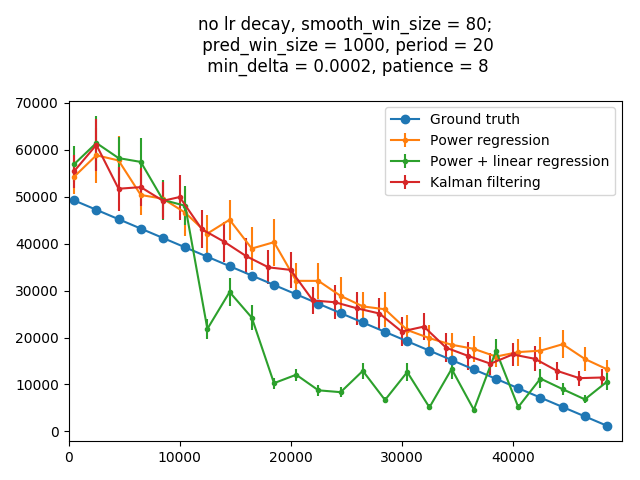

In [72]:
fig = plt.figure()

# ground truth
x = (start_point+(np.arange(len(preds)))*report_period)*num_epochs_between_eval
plt.plot(x, earlyStoppingStep-x,'-o')
legend = ['Ground truth']

# three methods
for alg in all_preds:
    plt.errorbar(all_steps[alg], np.array(all_preds[alg])-np.array(all_steps[alg]), all_errs[alg], fmt='.-')
    legend.append(alg)
    
plt.xlim(0,earlyStoppingStep+100)
plt.legend(legend)
plt.title('no lr decay, smooth_win_size = {4};\n pred_win_size = {0}, period = {1}\n min_delta = {2}, patience = {3}\n '.
          format(pred_win_size, period, min_delta, patience, smooth_win_size))
fig.tight_layout()

# save the image
dir_ = '/Users/stranot/Desktop/zeros/cifar10_lr_1e_1/'
plt.savefig(dir_ + 'images/min_delta_{:.0e}_patience_{}.png'.format(min_delta, patience))

# # store the results
# for key in all_preds:
#     all_preds[key] = list(all_preds[key])
#     all_errs[key] = list(all_errs[key])
#     all_steps[key] = list(all_steps[key])
# output = {}
# output['all_preds'] = all_preds
# output['all_errs'] = all_errs
# output['all_steps'] = all_steps
# with open(dir_ + 'jsons/min_delta_{:.0e}_patience_{}.json'.format(min_delta, patience), 'w+') as f:
#     json.dump(output, f)